This is meant to be essentially a direct C++ port of `tensorrt_inference_py.ipynb`. 

Getting TensorRT and Torchlib working with xeus-cling was a near hellish experience, but if it gets to the point where jupyter-notebooks work nicely with C++, that will be incredibly exciting.

# Libraries

## TensorRT

In [1]:
#pragma cling add_library_path("/home/justin/TensorRT-7.2.0.14/lib")

In [2]:
#pragma cling add_include_path("/home/justin/TensorRT-7.2.0.14/include")

In [3]:
#pragma cling load("libnvinfer")
#pragma cling load("libnvinfer_plugin")

## Cuda

In [4]:
#pragma cling add_library_path("/usr/local/cuda/lib64")

In [5]:
#pragma cling add_include_path("/usr/local/cuda/include")

In [6]:
#pragma cling load("libcudart")
#pragma cling load("libcublas")
#pragma cling load("libcudnn")

## Libtorch

In [7]:
#pragma cling add_library_path("/home/justin/pytorch/torch/lib")

In [8]:
#pragma cling add_include_path("/home/justin/pytorch/torch/include")
#pragma cling add_include_path("/home/justin/pytorch/torch/include/torch/csrc/api/include")

In [9]:
#pragma cling load("libtorch")

## OpenCV

In [10]:
#pragma cling add_library_path("/usr/local/lib/")

In [11]:
#pragma cling add_include_path("/usr/local/include/opencv4")

In [12]:
#pragma cling load("libopencv_core")
#pragma cling load("libopencv_imgcodecs")

# C++ Inference

## Includes

In [ ]:
#include <iostream>
#include <fstream>
#include <string>
#include <vector>

#include <cuda_runtime_api.h> 

#include "NvInfer.h" 
#include "NvInferPlugin.h"

#undef _OPENMP // Issues with openmp, so disable for now
#include <torch/torch.h>

#include <opencv2/opencv.hpp>
#include <opencv2/imgcodecs.hpp>
#include "nlohmann/json.hpp"
#include "xtl/xbase64.hpp"

## Utilities

In [14]:
auto get_file_size(const char* file) {
    std::ifstream in(file, std::ifstream::ate | std::ifstream::binary);
    return in.tellg(); 
}

In [15]:
auto read_file_data(const char* file, char* data) {
    auto sz = get_file_size(file);
    std::ifstream f(file, std::ifstream::binary);
    f.read(data, sz);
}

In [16]:
auto get_file_data(const char* file) {
    auto sz = get_file_size(file);
    std::vector<char> data(sz);
    read_file_data(file, data.data());
    return data;
}

In [17]:
auto volume(const nvinfer1::Dims& d) {
    return std::accumulate(d.d, d.d + d.nbDims, 1, std::multiplies<int64_t>());
}

Couldn't get torch::from_blob working in xeus-cling:

    https://github.com/jupyter-xeus/xeus-cling/issues/357

So I made a cheesy temporary replacement.

In [18]:
auto from_blob(void *ptr, at::IntArrayRef sizes, const at::TensorOptions &options) {
    if (options.dtype() == torch::kFloat32) {
        auto X = torch::zeros(sizes, options);
        auto numel = std::accumulate(sizes.data(), sizes.data()+sizes.size(), 1, std::multiplies<int64_t>());
        std::memcpy(X.data_ptr(), ptr, numel*sizeof(float));
        return X;
    } else {
        throw std::runtime_error("Only float supported for now");
    }
}

Use opencv to encode torch array into a png, then display with `mime_bundle_repr`

In [19]:
struct imshow {   
    inline imshow(const torch::Tensor& arr, float vmin, float vmax) {
        auto arr_float = arr.to(torch::TensorOptions().dtype(torch::kFloat32));
        arr_float = (arr_float-vmin)/(vmax-vmin)*255;
        auto arr_mat = cv::Mat(arr_float.sizes()[0], arr_float.sizes()[1], CV_32F, arr_float.data_ptr());
        std::vector<uchar> arr_png_char;
        cv::imencode(".png", arr_mat, arr_png_char);
        arr_png_str = std::string(arr_png_char.begin(), arr_png_char.end());
    }
    std::string arr_png_str;
};

In [20]:
nlohmann::json mime_bundle_repr(const imshow& i) {
    auto bundle = nlohmann::json::object();
    bundle["image/png"] = xtl::base64encode(i.arr_png_str);
    return bundle;
}

## Code

In [21]:
class Logger : public nvinfer1::ILogger {
    void log(nvinfer1::ILogger::Severity severity, const char* msg) override {
        std::cout << msg << std::endl;
    }
} logger;

In [22]:
initLibNvInferPlugins(&logger, "");

Registered plugin creator - ::GridAnchor_TRT version 1
Registered plugin creator - ::NMS_TRT version 1
Registered plugin creator - ::Reorg_TRT version 1
Registered plugin creator - ::Region_TRT version 1
Registered plugin creator - ::Clip_TRT version 1
Registered plugin creator - ::LReLU_TRT version 1
Registered plugin creator - ::PriorBox_TRT version 1
Registered plugin creator - ::Normalize_TRT version 1
Registered plugin creator - ::RPROI_TRT version 1
Registered plugin creator - ::BatchedNMS_TRT version 1
Registered plugin creator - ::BatchedNMSDynamic_TRT version 1
Registered plugin creator - ::FlattenConcat_TRT version 1
Registered plugin creator - ::CropAndResize version 1
Registered plugin creator - ::DetectionLayer_TRT version 1
Registered plugin creator - ::Proposal version 1
Registered plugin creator - ::ProposalLayer_TRT version 1
Registered plugin creator - ::PyramidROIAlign_TRT version 1
Registered plugin creator - ::ResizeNearest_TRT version 1
Registered plugin creator -

In [23]:
auto tensorrt_inference(const char* file_engine, const char* file_batch) {
    // Load engine
    auto runtime = nvinfer1::createInferRuntime(logger);
    auto data_engine = get_file_data(file_engine);
    auto engine = runtime->deserializeCudaEngine(data_engine.data(), data_engine.size(), nullptr);
    auto context = engine->createExecutionContext();

    // Allocate buffers
    float *X_h, *y_h, *X_d, *y_d;
    const auto nbytes_input  = volume(engine->getBindingDimensions(0))*sizeof(float);
    const auto nbytes_output = volume(engine->getBindingDimensions(1))*sizeof(float);
    cudaHostAlloc((void**)&X_h,  nbytes_input, cudaHostAllocDefault);
    cudaHostAlloc((void**)&y_h, nbytes_output, cudaHostAllocDefault);
    cudaMalloc((void**)&X_d,  nbytes_input);  
    cudaMalloc((void**)&y_d, nbytes_output);  

    // Read batch - assumes this is stored as float and already pre-processed
    read_file_data(file_batch, (char*)X_h);

    // Inference
    cudaStream_t stream;
    cudaStreamCreate(&stream);
    cudaMemcpyAsync(X_d,  X_h,  nbytes_input,  cudaMemcpyHostToDevice, stream); 
    context->enqueueV2(std::vector<void*>{X_d, y_d}.data(), stream, nullptr); 
    cudaMemcpyAsync(y_h, y_d, nbytes_output, cudaMemcpyDeviceToHost, stream); 
    cudaStreamSynchronize(stream);
    // couldnt get torch::from_blob() working with xeus cling, so use from_blob replacement function for now
    auto y = from_blob(y_h, {1, 5, 384, 512}, torch::TensorOptions().dtype(torch::kFloat32));
    y = y.argmax(1).squeeze(0);
    
    return y;
}

In [24]:
auto file_engine = "training/attempt_2/model_8.engine";
auto file_batch  = "batches_trn/X0.raw";
auto y = tensorrt_inference(file_engine, file_batch)

Deserialize required 679776 microseconds.
Allocated persistent device memory of size 2401792
Allocated activation device memory of size 16343040
Assigning persistent memory blocks for various profiles


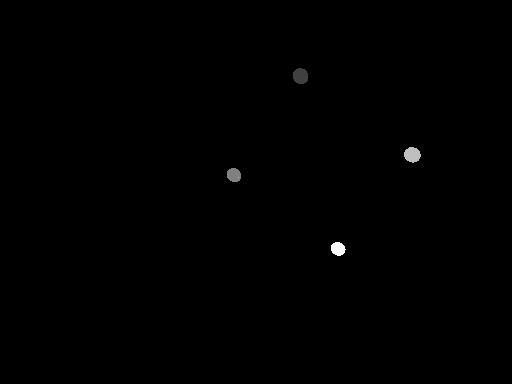

In [25]:
imshow im(y, 0, 4);
im